# <span style="color:green"> Bi-LSTM RNN 

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.cross_validation import train_test_split
import pylab as pl
from IPython import display
import sys
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Bi-LSTM class and functions

In [2]:
class Bi_LSTM_cell(object):


    def __init__(self, input_size, hidden_layer_size, target_size):

        # Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size

        # Weights and Bias for input and hidden tensor for forward pass
        self.Wi = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Ui = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size]))

        
        self.Wf = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uf = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wog = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uog = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wc = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uc = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bc = tf.Variable(tf.zeros([self.hidden_layer_size]))        

        
        
        # Weights and Bias for input and hidden tensor for backward pass
        self.Wi1 = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Ui1 = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bi1 = tf.Variable(tf.zeros([self.hidden_layer_size]))

        
        self.Wf1 = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uf1 = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bf1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wog1 = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uog1 = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bog1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wc1 = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uc1 = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bc1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        
        # Weights for output layers
        self.Wo = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size*2, self.target_size],mean=0,stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.target_size],mean=0,stddev=.01))

        # Placeholder for input vector with shape[batch, timesteps, features]
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')
        
        #Reversing the inputs by timesteps for backward pass of the LSTM
        self._inputs_rev= tf.reverse(self._inputs,[1]) 
        # tf.reverse，沿著維度進行反轉，[1]也就是從第2維度進行反轉，timesteps部分的進行反轉
        
        # Processing inputs to work with scan function
        self.processed_input = process_batch_input_for_RNN(self._inputs)
        
        #For bacward pass of the LSTM
        self.processed_input_rev = process_batch_input_for_RNN(self._inputs_rev)
        

        self.initial_hidden = self._inputs[:, 0, :]
        self.initial_hidden= tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size]))
        
        
        self.initial_hidden=tf.stack([self.initial_hidden,self.initial_hidden])
        
    # Function for Forward LSTM cell. 
    def Lstm_f(self, previous_hidden_memory_tuple, x):
        
        previous_hidden_state,c_prev=tf.unstack(previous_hidden_memory_tuple)
        
        #Input Gate
        i= tf.sigmoid(
            tf.matmul(x,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi 
        )
        
        #Forget Gate
        f= tf.sigmoid(
            tf.matmul(x,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf 
        )
        
        #Output Gate
        o= tf.sigmoid(
            tf.matmul(x,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog
        )
        
        #New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(x,self.Wc)+tf.matmul(previous_hidden_state,self.Uc) + self.bc 
        ) 
        
        #Final Memory cell
        c= f*c_prev + i*c_
        
        #Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)


        return tf.stack([current_hidden_state,c])

    # Function for Forward LSTM cell. 
    def Lstm_b(self, previous_hidden_memory_tuple, x):
        
        previous_hidden_state,c_prev=tf.unstack(previous_hidden_memory_tuple)
        
        #Input Gate
        i= tf.sigmoid(
            tf.matmul(x,self.Wi1)+tf.matmul(previous_hidden_state,self.Ui1) + self.bi1
        )
        
        #Forget Gate
        f= tf.sigmoid(
            tf.matmul(x,self.Wf1)+tf.matmul(previous_hidden_state,self.Uf1) + self.bf1 
        )
        
        #Output Gate
        o= tf.sigmoid(
            tf.matmul(x,self.Wog1)+tf.matmul(previous_hidden_state,self.Uog1) + self.bog1
        )
        
        #New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(x,self.Wc1)+tf.matmul(previous_hidden_state,self.Uc1) + self.bc1 
        ) 
        
        #Final Memory cell
        c= f*c_prev + i*c_
        
        #Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)


        return tf.stack([current_hidden_state,c])    
    
    

    #Function to get the hidden and memory cells after forward pass
    def get_states_f(self):

        # Getting all hidden state throuh time
        all_hidden_memory_states = tf.scan(self.Lstm_f,
                                    self.processed_input,
                                    initializer=self.initial_hidden,
                                    name='states')
        
        # [timesteps, 2, batch, hidden_layer_size]，第二維是由hidden_states及cell組成
        all_hidden_states=all_hidden_memory_states[:,0,:,:] 
        all_memory_states=all_hidden_memory_states[:,1,:,:]

        
        return all_hidden_states,all_memory_states

    
    #Function to get the hidden and memory cells after backward pass
    def get_states_b(self):
        
        all_hidden_states, all_memory_states = self.get_states_f() # 拿forward pass的hidden_state及cell
        
        #Reversing the hidden and memory state to get the final hidden and memory state
        last_hidden_states = all_hidden_states[-1] # 拿出最後一個timestep
        last_memory_states = all_memory_states[-1] # 拿出最後一個timestep
        
        #For backward pass using the last hidden and memory of the forward pass
        initial_hidden=tf.stack([last_hidden_states,last_memory_states]) # forward最後一步timestep的值作為backward的initial
        
        # Getting all hidden state throuh time
        all_hidden_memory_states = tf.scan(self.Lstm_b,
                                    self.processed_input_rev,
                                    initializer=initial_hidden,
                                    name='states')
        
        
        #Now reversing the states to keep those in original order
        # 挑出hidden_states及cell的tensor後在對timesteps的維度進行反轉，還原成原本的timesteps順序
        all_hidden_states=tf.reverse(all_hidden_memory_states[:,0,:,:],[0]) # [timesteps, batch, hidden_layer_size] 
        all_memory_states=tf.reverse(all_hidden_memory_states[:,1,:,:],[0])

        
        return all_hidden_states,all_memory_states
    
    
    #Function to concat the hiddenstates for backward and forward pass
    def get_concat_hidden(self):
        
        #Getting hidden and memory for the forward pass
        all_hidden_states_f, all_memory_states_f = self.get_states_f() # 拿出forward的hidden_state與cell
        
        #Getting hidden and memory for the backward pass
        all_hidden_states_b, all_memory_states_b = self.get_states_b() # 拿出backward的hidden_state與cell
        
        # tf.concat沿著某一維度連接兩個tensor，axis=2表示沿著hidden_layer_size進行concat，shape會變成[timesteps,batch,2*hidden_layer_size]
        #Concating the hidden states of forward and backward pass
        concat_hidden=tf.concat([all_hidden_states_f,all_hidden_states_b],2)
        
        return concat_hidden


    # Function to get output from a hidden layer
    def get_output(self, hidden_state):

        #output = tf.nn.sigmoid(tf.matmul(hidden_state, self.Wo) + self.bo)
        output = tf.matmul(hidden_state, self.Wo) + self.bo
        return output

    # Function for getting all output layers
    def get_outputs(self):

        all_hidden_states = self.get_concat_hidden() # shape[timesteps,batch,2*hidden_layer_size]

        all_outputs = tf.map_fn(self.get_output, all_hidden_states) # 對每一個timesteps使用get_output，輸出class數

        return all_outputs


# Function to convert batch input data to use scan tf.ops of tensorflow.
def process_batch_input_for_RNN(batch_input):

    batch_input_ = tf.transpose(batch_input, perm=[1, 0, 2])
    X = tf.transpose(batch_input_)

    return X


# Placeholder and initializers


In [3]:
hidden_layer_size = 50
input_size = 8
target_size = 10

In [4]:
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')

# Models

In [5]:
#Initializing rnn object
rnn=Bi_LSTM_cell( input_size, hidden_layer_size, target_size)

In [6]:
#Getting all outputs from rnn
outputs = rnn.get_outputs()
concat_hidden = rnn.get_concat_hidden()

In [7]:
#Getting first output through indexing
last_output = outputs[-1]

In [8]:
#Computing the Cross Entropy loss 
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_output, labels=y))

In [9]:
# Trainning with Adadelta Optimizer
train_step = tf.train.AdamOptimizer().minimize(loss)

In [10]:
#Calculatio of correct prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(last_output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

# Dataset Preparation

In [11]:
#Function to get on hot
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot
    

In [12]:
#Using Sklearn MNIST dataset.
digits = datasets.load_digits()
X=digits.images
Y_=digits.target

Y=list(map(get_on_hot,Y_))

In [13]:
#Getting Train and test Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=42)

#Cuttting for simple iteration
X_train=X_train[:1400]
y_train=y_train[:1400]

In [14]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
#Iterations to do trainning
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(120):
    
    start=0
    end=100
    
    train_loss_collector = []
    test_loss_collector = []
    train_acc_collector = []
    test_acc_collector = []
    
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        start=end
        end=start+100 # 每次訓練100張圖片
        _, train_loss_batch, train_acc_batch = sess.run([train_step, loss, accuracy],feed_dict={rnn._inputs:X, y:Y})
        
        train_loss_collector.append(train_loss_batch)
        train_acc_collector.append(train_acc_batch)
    
    concat_hidden1 = sess.run([concat_hidden], feed_dict={rnn._inputs:X})
    train_loss_collector = np.mean(train_loss_collector) # 平均一個batch的loss
    train_acc_collector = np.mean(train_acc_collector) # 平均一個batch的acc
    
    train_loss.append(train_loss_collector)
    train_acc.append(train_acc_collector)
    
    #Loss=str(sess.run(cross_entropy,feed_dict={rnn._inputs:X, y:Y}))
    #Train_accuracy=sess.run(accuracy,feed_dict={rnn._inputs:X_train[:500], y:y_train[:500]})
    
    test_loss_=sess.run(loss,feed_dict={rnn._inputs:X_test, y:y_test})
    test_acc_=sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test})
    
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
        
    print('Epoch=%d/120, train_loss=%.2f, train_acc=%.2f / test_loss=%.2f, test_acc=%.2f' % 
          (epoch+1, train_loss_collector, train_acc_collector, test_loss_, test_acc_))

Epoch=1/120, train_loss=228.85, train_acc=26.64 / test_loss=891.71, test_acc=34.34
Epoch=2/120, train_loss=214.66, train_acc=35.93 / test_loss=778.08, test_acc=33.08
Epoch=3/120, train_loss=180.17, train_acc=44.14 / test_loss=618.75, test_acc=55.05
Epoch=4/120, train_loss=140.28, train_acc=64.21 / test_loss=454.66, test_acc=71.72
Epoch=5/120, train_loss=105.01, train_acc=73.93 / test_loss=337.73, test_acc=78.79
Epoch=6/120, train_loss=81.69, train_acc=79.14 / test_loss=263.27, test_acc=84.85
Epoch=7/120, train_loss=65.36, train_acc=82.86 / test_loss=215.52, test_acc=88.38
Epoch=8/120, train_loss=53.57, train_acc=85.57 / test_loss=179.37, test_acc=89.65
Epoch=9/120, train_loss=44.66, train_acc=88.07 / test_loss=150.96, test_acc=90.91
Epoch=10/120, train_loss=37.89, train_acc=89.57 / test_loss=127.21, test_acc=92.93
Epoch=11/120, train_loss=32.67, train_acc=90.71 / test_loss=109.54, test_acc=93.18
Epoch=12/120, train_loss=28.16, train_acc=91.79 / test_loss=96.33, test_acc=93.69
Epoch=13/

Epoch=102/120, train_loss=0.16, train_acc=100.00 / test_loss=27.83, test_acc=98.23
Epoch=103/120, train_loss=0.16, train_acc=100.00 / test_loss=27.89, test_acc=98.23
Epoch=104/120, train_loss=0.16, train_acc=100.00 / test_loss=27.94, test_acc=98.23
Epoch=105/120, train_loss=0.15, train_acc=100.00 / test_loss=27.99, test_acc=98.23
Epoch=106/120, train_loss=0.15, train_acc=100.00 / test_loss=28.04, test_acc=98.23
Epoch=107/120, train_loss=0.15, train_acc=100.00 / test_loss=28.09, test_acc=98.23
Epoch=108/120, train_loss=0.14, train_acc=100.00 / test_loss=28.14, test_acc=98.23
Epoch=109/120, train_loss=0.14, train_acc=100.00 / test_loss=28.20, test_acc=98.23
Epoch=110/120, train_loss=0.14, train_acc=100.00 / test_loss=28.25, test_acc=98.23
Epoch=111/120, train_loss=0.14, train_acc=100.00 / test_loss=28.30, test_acc=98.23
Epoch=112/120, train_loss=0.13, train_acc=100.00 / test_loss=28.35, test_acc=98.23
Epoch=113/120, train_loss=0.13, train_acc=100.00 / test_loss=28.40, test_acc=98.23
Epoc

In [16]:
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (12,8)

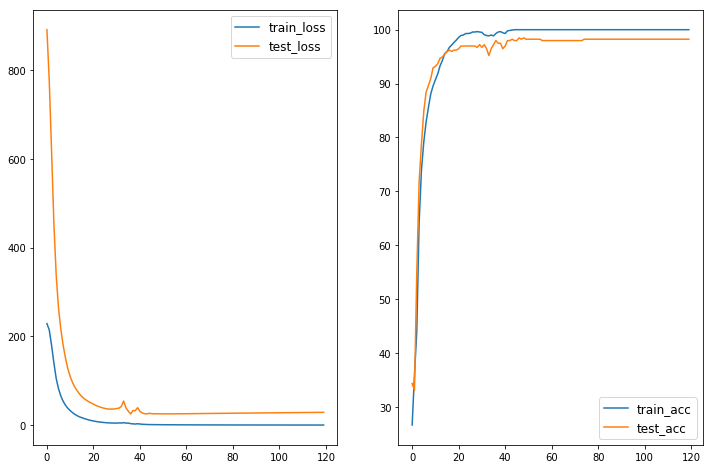

In [17]:
fig, axes = plt.subplots(1,2)

axes[0].plot(np.arange(120), train_loss, label='train_loss')
axes[0].plot(np.arange(120), test_loss, label='test_loss')
axes[0].legend(loc='upper right',prop={'size':12})

axes[1].plot(np.arange(120), train_acc, label='train_acc')
axes[1].plot(np.arange(120), test_acc, label='test_acc')
axes[1].legend(loc='lower right',prop={'size':12})

plt.show()

In [18]:
print('Min train loss:%.2f' % np.min(train_loss))
print('Max train accuracy:%.2f' % np.max(train_acc))
print('------------------------')
print('Min test loss:%.2f' % np.min(test_loss))
print('Max test accuracy:%.2f' % np.max(test_acc))

Min train loss:0.11
Max train accuracy:100.00
------------------------
Min test loss:25.09
Max test accuracy:98.48
